# Detailed Evaluation

This notebook shows how to produce some tables and plots for analysing results. This is meant as a starting point, because eah game will require a custom evaluation depending on its metrics and experiments.

This notebook uses the output files of evaluation/bencheval.py. Run that first.

In [11]:
import sys
# sys.path.append('..')

from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import clemgame.metrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [138]:
RAW_PATH = Path('results/raw.csv')
# RAW_PATH = 'results/raw.csv'
# RAW_PATH = Path('\\results\\raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Let's inspect the contents of ```data```:

In [139]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
19835,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_5,Played,0.0
19836,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_6,Played,1.0
19837,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_7,Played,1.0
19838,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_8,Played,0.0


If we want to evaluate a single game and the results directory contained more games, we can filter the game column:

In [140]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
19835,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_5,Played,0.0
19836,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_6,Played,1.0
19837,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_7,Played,1.0
19838,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_8,Played,0.0


## Overview tables

Get dispersion metrics over all episodes. Note that we use groupby, which will ignore NaN values, according to the documentation!

In [141]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean   
game          model                                              metric                               
adventuregame Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Ins... Aborted                   0.640625  \
                                                                 Lose                      0.656250   
                                                                 Main Score                0.099499   
                                                                 Parsed Request Count     18.234375   
                                                                 Played                    0.359375   
...                                                                                             ...   
              openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5... turns_over_par           10.000000   
                                                                 undefined_action          0.000000   
                                                                 undefined_action_verb     3.375000   
                                                                 undefined_argument_type   0.000000   
                                                                 undefined_repr_str        0.718750   

                                                                                                std   
game          model                                              metric                               
adventuregame Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Ins... Aborted                   0.483610  \
                                                                 Lose                      0.478714   
                                                                 Main Score                0.167637   
                                                                 Parsed Request Count     10.433070   
                                                                 Played                    0.483610   
...                                                                                             ...   
              openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5... turns_over_par           11.313708   
                                                                 undefined_action          0.000000   
                                                                 undefined_action_verb    11.335434   
                                                                 undefined_argument_type   0.000000   
                                                                 undefined_repr_str        3.538759   

                                                                                                 var   
game          model                                              metric                                
adventuregame Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Ins... Aborted                    0.233879  \
                                                                 Lose                       0.229167   
                                                                 Main Score                 0.028102   
                                                                 Parsed Request Count     108.848958   
                                                                 Played                     0.233879   
...                                                                                              ...   
              openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5... turns_over_par           128.000000   
                                                                 undefined_action           0.000000   
                                                                 undefined_action_verb    128.492063   
                                                                 undefined_argument_type    0.000000   
                                                                 undefined_repr_str        12.522817   

                                                              

Break results down by experiment:

In [142]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean   
game          model                                              experiment                         metric                               
adventuregame Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Ins... 0_home_deliver_three_basic_easy    Aborted                   0.437500  \
                                                                                                    Lose                      0.437500   
                                                                                                    Main Score                0.079044   
                                                                                                    Parsed Request Count     17.312500   
                                                                                                    Played                    0.562500   
...                                                                                                                                ...   
              openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5... 3_home_deliver_three_planning_hard turns_over_par                 NaN   
                                                                                                    undefined_action          0.000000   
                                                                                                    undefined_action_verb     0.937500   
                                                                                                    undefined_argument_type   0.000000   
                                                                                                    undefined_repr_str        2.687500   

                                                                                                                                  std   
game          model                                              experiment                         metric                              
adventuregame Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Ins... 0_home_deliver_three_basic_easy    Aborted                  0.512348  \
                                                                                                    Lose                     0.512348   
                                                                                                    Main Score               0.134972   
                                                                                                    Parsed Request Count     7.162111   
                                                                                                    Played                   0.512348   
...                                                                                                                               ...   
              openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5... 3_home_deliver_three_planning_hard turns_over_par                NaN   
                                                                                                    undefined_action         0.000000   
                                                                                                    undefined_action_verb    2.462214   
                                                                                                    undefined_argument_type  0.000000   
                                                                                                    undefined_repr_str       6.848053   

                                                                                                                                   var   
game          model                                              experiment                         metric                               
adventuregame Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Ins... 0_home_deliver_three_basic_easy    Aborted                   0.262500  \
                                                                                                    Lose                      0.262500   
 

To save the table, call ```to_csv```, ```to_html``` and/or ```to_latex``` (there are also other formats and customization options, check the pandas docs):

In [144]:
#stats_df.to_csv('../results/stats.csv')
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

Planning variant:

In [68]:
# plan_experiments = ['1_home_deliver_three_planning_easy', '3_home_deliver_three_planning_hard']
# plan_df = game_df[game_df.experiment in plan_experiments]
plan_easy_df = game_df[game_df.experiment == '1_home_deliver_three_planning_easy']
plan_hard_df = game_df[game_df.experiment == '3_home_deliver_three_planning_hard']

plan_dfs = [plan_easy_df, plan_hard_df]
plan_df = pd.concat(plan_dfs)
plan_df

,game,model,experiment,episode,metric,value
624,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,1_home_deliver_three_planning_easy,episode_0,Violated Request Count,1.000
625,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,1_home_deliver_three_planning_easy,episode_0,Parsed Request Count,7.000
626,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,1_home_deliver_three_planning_easy,episode_0,Request Count,8.000
627,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,1_home_deliver_three_planning_easy,episode_0,Request Success Ratio,0.875
628,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,1_home_deliver_three_planning_easy,episode_0,hallucination_count,0.000
...,...,...,...,...,...,...
19835,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_5,Played,0.000
19836,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_6,Played,1.000
19837,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_7,Played,1.000
19838,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_8,Played,0.000


Hallucinations:

In [87]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
43,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_1,hallucination_count,0.0
82,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_10,hallucination_count,0.0
121,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_11,hallucination_count,0.0
160,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_12,hallucination_count,0.0
...,...,...,...,...,...,...
19153,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_5,hallucination_count,0.0
19192,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_6,hallucination_count,0.0
19231,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_7,hallucination_count,0.0
19270,adventuregame,openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q...,3_home_deliver_three_planning_hard,episode_8,hallucination_count,0.0


In [127]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:8, [4]]
hallucination_sums

,value
model,
Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0,19.0
Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0,4.0
gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0,5.0
gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0,6.0
gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0,5.0
llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0,14.0
llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0,0.0
openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0,4.0


In [145]:
hallucination_sums.to_latex('results/hallucination_sums.tex')

In [89]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0,0.296875,0.460493,0.212054,0.0,1.0,0.0,0.910665
Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124
gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0,0.078125,0.270490,0.073165,0.0,1.0,0.0,3.219966
gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0,0.093750,0.293785,0.086310,0.0,1.0,0.0,2.854843
gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0,0.078125,0.270490,0.073165,0.0,1.0,0.0,3.219966
llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0,0.218750,0.416667,0.173611,0.0,1.0,0.0,1.393548
llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124


## Basic Plots

Plots can of course be created with ```matplotlib``` directly, but ```seaborn``` makes it very easy to work with pandas dataframes. Let's create a barplot with an overview by model and experiment:

In [132]:
# choose a metric
METRIC = 'Main Score'
metric_df = game_df[game_df.metric == METRIC].sort_values('experiment')

In [134]:
# choose a metric
METRIC = 'achieved_goal_ratio'
metric_df = game_df[game_df.metric == METRIC].sort_values('experiment')

In [83]:
# choose a metric
METRIC = 'turn_ratio'
metric_df = game_df[game_df.metric == METRIC].sort_values('experiment')

In [136]:
# choose a metric
METRIC = 'finish_speed'
metric_df = game_df[game_df.metric == METRIC].sort_values('experiment')

In [75]:
# choose a metric
METRIC = 'bad_plan_follow_ratio'
metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')

C:\Users\JJ\AppData\Local\Temp\ipykernel_21312\2200469796.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')


In [77]:
# choose a metric
METRIC = 'bad_plan_dismiss_ratio'
metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')

C:\Users\JJ\AppData\Local\Temp\ipykernel_21312\2815346986.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')


In [79]:
# choose a metric
METRIC = 'plan_followed_ratio'
metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')

C:\Users\JJ\AppData\Local\Temp\ipykernel_21312\3252478211.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')


In [81]:
# choose a metric
METRIC = 'plan_average_viability_ratio'
metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')

C:\Users\JJ\AppData\Local\Temp\ipykernel_21312\605928773.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = plan_df[game_df.metric == METRIC].sort_values('experiment')


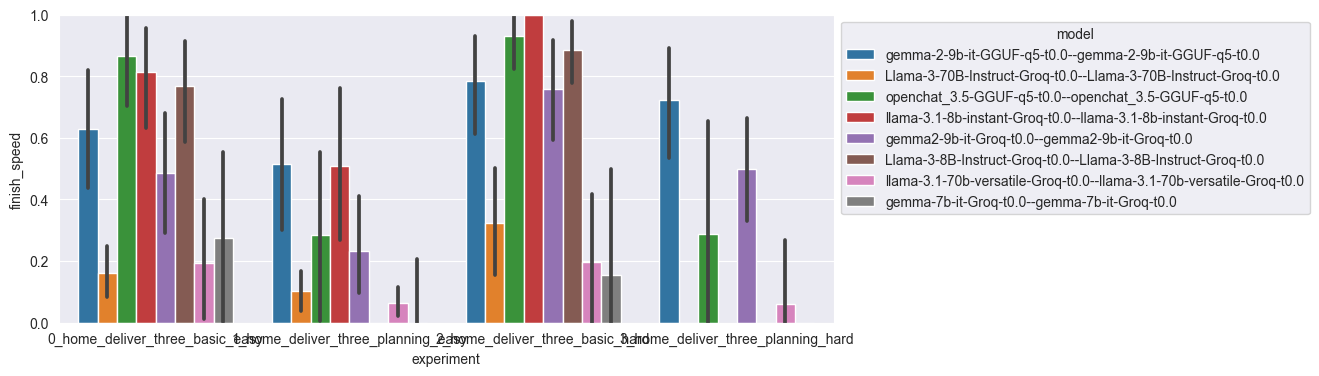

In [137]:
# change the figure size according to your needs
fig, ax = plt.subplots(figsize=(10, 4))

# choose what goes in each axis and legend according to your needs
# you can also e.g. swap y and hue, to get games in the legend and models in the axis
g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

# customize plot details according to your needs
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 1)
plt.ylabel(METRIC)

plt.show()

## Benchmark plots

Reproducing Figure 10 in the paper. As more models or games are added, sizes must be adjusted accordingly:

In [129]:
# read the clem scores
# RESULTS_PATH = Path('../results/results.csv')
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Horizontal bar plot with player, aborted, lost:

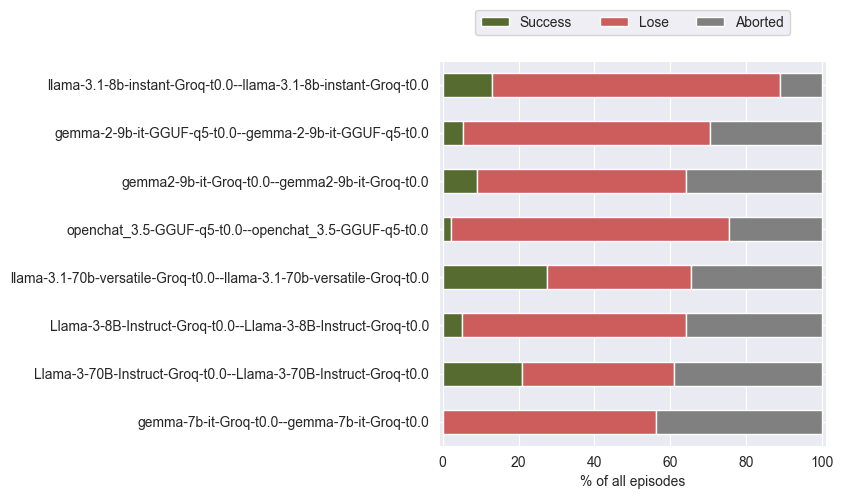

In [130]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with the sorted clemscores (they were not sorted in the paper):

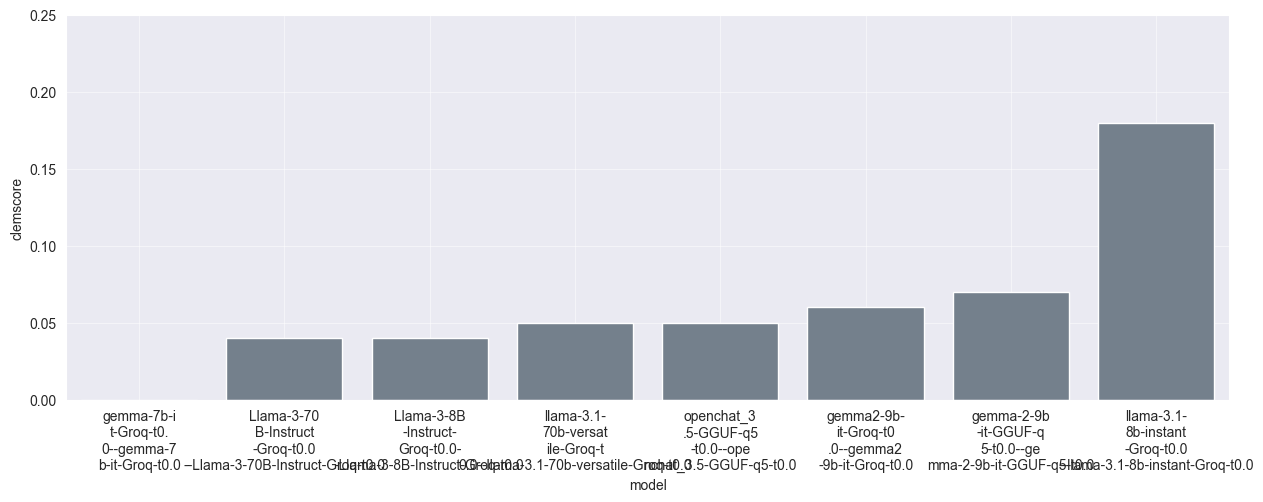

In [131]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model')
# below is a hack to make the current names fit the plot
# ideally a dictionary with short names should be used as in the original implementation for the paper
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 0.25)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Polygons. This can get complicated if more games are added. In particular, COLUMN_ORDER must be adjusted. For more models, the number of subplots and figsize must be adjusted.

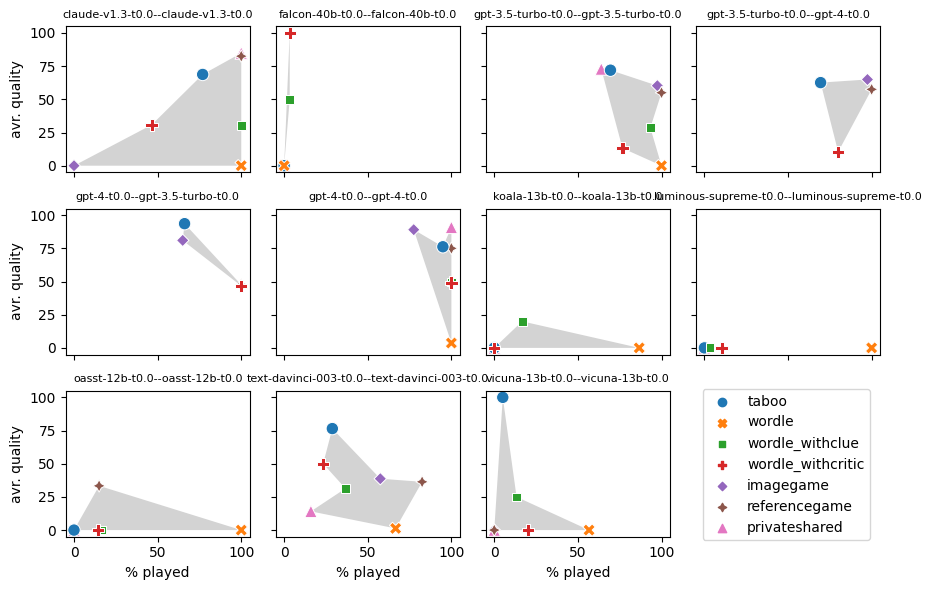

In [13]:
def ccw_sort(p):
    """Put the nodes in clockwise order."""
    # from https://stackoverflow.com/a/44143444 by user ImportanceOfBeingEarnest
    p = np.array(p)
    mean = np.mean(p, axis=0)
    d = p - mean
    s = np.arctan2(d[:, 0], d[:, 1])
    return p[np.argsort(s), :]


fig, ax_list = plt.subplots(3, 4, figsize=(9, 6), sharey=True, sharex=True)
axs = ax_list.flatten()

for n, (model, model_df) in enumerate(raw_df.groupby('model')):
    rows = model_df.metric.isin(utils.MAIN_METRICS)
    df_aux = model_df[rows]
    df_aux = (df_aux.pivot(index=['game', 'experiment', 'episode'],
                            columns='metric',
                            values='value')
                    .reset_index())
    df_aux = df_aux.drop(['episode'], axis=1)

    # create the x and y coordinates for each game
    dots = []
    for game, game_df in df_aux.groupby('game'):
        overall_means = (game_df.mean(numeric_only=True)
                                .fillna(0))
        # replace missing score by 0 when all aborted
        played = overall_means[clemmetrics.METRIC_PLAYED] * 100
        score = overall_means[clemmetrics.BENCH_SCORE]
        dots.append((game, played, score))
    labels, played, scores = zip(*dots)
    # put them in a good order for the polygon
    edges = ccw_sort(list(zip(played, scores)))

    # create the polygon and draw it
    polygon = Polygon(edges, facecolor='lightgray')
    axs[n].add_patch(polygon)

    legend = True if n == 10 else False
    g = sns.scatterplot(x=played,
                        y=scores,
                        hue=labels,
                        style=labels,
                        hue_order=utils.COLUMN_ORDER[1:],
                        style_order=utils.COLUMN_ORDER[1:],
                        s=80,
                        ax=axs[n],
                        legend=legend)
    axs[n].set_xlim(-5, 105)
    axs[n].set_ylim(-5, 105)
    axs[n].set_ylabel('avr. quality')
    axs[n].set_xlabel('% played')
    axs[n].set_title(model, fontsize=8)

fig.legend(loc='lower right', bbox_to_anchor=(0.98, 0.08))
axs[10].legend().set_visible(False)
fig.delaxes(axs[11])
plt.tight_layout()
plt.show()